# Plotting

This notebook shows how to select part of the gametime dataset and how to visualize the
dataset with [seaborn](https://seaborn.pydata.org/). All cells can be executed directly
in the notebook. Order of execution matter, variables declared in a cell will only be
available to another cell after its execution.

## Concepts and background

The dataset is stored in a CSV file and is both read and written by 
[pandas](https://pandas.pydata.org/). The plotting is handled through 
[seaborn](https://seaborn.pydata.org/). Introduction to both libraries can be very
informative:

- [pandas intro](https://pandas.pydata.org/docs/getting_started/index.html)
- [seaborn intro](https://seaborn.pydata.org/tutorial/introduction.html)

## Imports and reading the dataset

The cell below will import all the functions and constants we need in this notebook.

In [1]:
import pandas as pd
import seaborn as sns

from wp.gametime import DF_DTYPES
from wp.utils.dataframe import prepare_dataframe, select_datetimes, select_steam_ids
from wp.utils.viz import make_plot_prettier

%matplotlib inline

Next, we need to define which file we are going to read. For this introduction purposes,
we'll use a sample file shipped with this package. If you want to use a different file,
ignore the cell below and enter the `gametime.csv` full file path in the variable 
`fname`.

In [2]:
# ignore this cell if you want to run the introduction/demo, else provide the file path
# to your dataset
fname: str = ""

In [3]:
from importlib.resources import files

fname = files("wp.tests") / "data" / "gametime.csv"

Now that we know which file we are going to read, we can open it with `pd.read_csv`. 
We include some non-default argument to:
- force the datatype of the different columns (`str` for `steam_id` and `game_id`, ...)
- parse the datetime from the `acq_time` column

In [4]:
df = pd.read_csv(fname, index_col=0, dtype=DF_DTYPES, parse_dates=["acq_time"])

We can render the dataframe inline in this notebook:

In [5]:
df

,steam_id,acq_time,game_time,game_id,game_time_diff
0,76561198329580271,2024-04-12 10:40:06+00:00,0,2163350,NaN
1,76561198329580271,2024-04-12 11:40:53+00:00,8,2163350,8.0
2,76561198329580271,2024-04-12 12:41:01+00:00,12,2163350,4.0
3,76561198329580271,2024-04-12 13:41:16+00:00,32,2163350,20.0
4,76561198329580271,2024-04-12 14:41:26+00:00,62,2163350,30.0
...,...,...,...,...,...
75,76561198329580279,2024-04-12 13:41:16+00:00,38,78000,18.0
76,76561198329580279,2024-04-12 14:41:26+00:00,42,78000,4.0
77,76561198329580279,2024-04-12 15:41:29+00:00,49,78000,7.0
78,76561198329580279,2024-04-12 16:41:31+00:00,61,78000,12.0


To explore the dataset, let's have a look at the different acquisition times and the
different steam IDs present.

In [6]:
df["steam_id"].unique()

array(['76561198329580271', '76561198329580270', '76561198329580272',
       '76561198329580273', '76561198329580274', '76561198329580275',
       '76561198329580276', '76561198329580277', '76561198329580278',
       '76561198329580279'], dtype=object)

In [7]:
df["acq_time"].unique()

<DatetimeArray>
['2024-04-12 10:40:06+00:00', '2024-04-12 11:40:53+00:00',
 '2024-04-12 12:41:01+00:00', '2024-04-12 13:41:16+00:00',
 '2024-04-12 14:41:26+00:00', '2024-04-12 15:41:29+00:00',
 '2024-04-12 16:41:31+00:00', '2024-04-12 17:41:33+00:00']
Length: 8, dtype: datetime64[ns, UTC]

## Select part of the dataset

The functions `prepare_dataframe`, `select_datetimes`, and `select_steam_ids` are used
to prepare the dataset before plotting and to select data spans.

- `prepare_dataframe` will map the steam IDs to usernames/tokens and map the game IDs to
  game names. It will make plot prettier!
- `select_steam_ids` will select a limited list of steam IDs. Attention, if the steam ID
  was map to a username, the username should be used to select this user.
- `select_datetimes` will select a time span and will resample the dataset.

### Prepare the dataset

In [8]:
mapping = {"76561198329580271": "necromancia"}  # let's map this username on the ID
df = prepare_dataframe(df, mapping)

In [9]:
df

,steam_id,acq_time,game_time,game_id,game_time_diff
0,necromancia,2024-04-12 10:40:06+00:00,0,Ecorescue,NaN
1,necromancia,2024-04-12 11:40:53+00:00,8,Ecorescue,8.0
2,necromancia,2024-04-12 12:41:01+00:00,12,Ecorescue,4.0
3,necromancia,2024-04-12 13:41:16+00:00,32,Ecorescue,20.0
4,necromancia,2024-04-12 14:41:26+00:00,62,Ecorescue,30.0
...,...,...,...,...,...
75,76561198329580279,2024-04-12 13:41:16+00:00,38,Bejeweled,18.0
76,76561198329580279,2024-04-12 14:41:26+00:00,42,Bejeweled,4.0
77,76561198329580279,2024-04-12 15:41:29+00:00,49,Bejeweled,7.0
78,76561198329580279,2024-04-12 16:41:31+00:00,61,Bejeweled,12.0


### Select steam IDs

Let's select only 2 steam IDs, `76561198329580279` and the recently mapped 
`necromancia`.

In [10]:
df = select_steam_ids(df, ["necromancia", "76561198329580279"])

In [11]:
df

,steam_id,acq_time,game_time,game_id,game_time_diff
0,necromancia,2024-04-12 10:40:06+00:00,0,Ecorescue,NaN
1,necromancia,2024-04-12 11:40:53+00:00,8,Ecorescue,8.0
2,necromancia,2024-04-12 12:41:01+00:00,12,Ecorescue,4.0
3,necromancia,2024-04-12 13:41:16+00:00,32,Ecorescue,20.0
4,necromancia,2024-04-12 14:41:26+00:00,62,Ecorescue,30.0
5,necromancia,2024-04-12 15:41:29+00:00,62,Ecorescue,0.0
6,necromancia,2024-04-12 16:41:31+00:00,68,Ecorescue,6.0
7,necromancia,2024-04-12 17:41:33+00:00,75,Ecorescue,7.0
8,76561198329580279,2024-04-12 10:40:06+00:00,0,Bejeweled,NaN
9,76561198329580279,2024-04-12 11:40:53+00:00,6,Bejeweled,6.0


### Select time span and resampled

`select_datetimes` takes 3 arguments in input: `start`, `end` and `freq`. At least one
of the arguments must be provided. 

*Note: if you want help with any function, just enter `function_name?` in a cell. You 
can click on `View as a scrollable element` if the output is truncated.*

In [12]:
select_datetimes?

Signature:
select_datetimes(
    df: pandas.core.frame.DataFrame,
    start: str | pandas._libs.tslibs.timestamps.Timestamp | None = None,
    end: str | pandas._libs.tslibs.timestamps.Timestamp | None = None,
    freq: str | pandas._libs.tslibs.timedeltas.Timedelta | None = None,
) -> pandas.core.frame.DataFrame
Docstring:
Select and resample datetimes from the dataframe.

Parameters
----------
df : pd.DataFrame
    The DataFrame with the gametime data. The DataFrame should have columns
    ``"steam_id"``, ``"acq_time"``, ``"game_time"``, ``"game_id"`` and
    ``"game_time_diff"``.
start : str | pd.Timestamp | None
    Start datetime to select. If None, the minimum datetime in the dataframe is
    used. If a string is provided, it should be in the format 'YYYY-MM-DD HH:MM:SS'.
    In the string format, part of the string can be omitted, for instance
    'YYYY-MM-DD' or 'YYYY-MM-DD HH:MM'.
end : str | pd.Timestamp | None
    End datetime to select. If None, the maximum datetime in the 

Anyway, this sample dataset has 8 timepoints, spaced by 1 hour on the 12th of April 
2024.

In [13]:
df["acq_time"].unique()

<DatetimeArray>
['2024-04-12 10:40:06+00:00', '2024-04-12 11:40:53+00:00',
 '2024-04-12 12:41:01+00:00', '2024-04-12 13:41:16+00:00',
 '2024-04-12 14:41:26+00:00', '2024-04-12 15:41:29+00:00',
 '2024-04-12 16:41:31+00:00', '2024-04-12 17:41:33+00:00']
Length: 8, dtype: datetime64[ns, UTC]

We can select the dates from 12h to 17h with a spacing (frequency) of 2 hours:

In [14]:
df = df.copy(deep=True)  # let's make a copy to try different selection
df_sel = select_datetimes(
    df, start="2024-04-12 12:00", end="2024-04-12 17:00", freq="3h"
)

In [15]:
df_sel

,steam_id,acq_time,game_time,game_id,game_time_diff
0,necromancia,2024-04-12 12:41:01+00:00,12,Ecorescue,NaN
1,necromancia,2024-04-12 14:41:26+00:00,62,Ecorescue,50.0
2,76561198329580279,2024-04-12 12:41:01+00:00,20,Bejeweled,NaN
3,76561198329580279,2024-04-12 14:41:26+00:00,42,Bejeweled,22.0


That's weird, our 2 selected time-points are spread by 2 hours instead of 3 hours as
requested. Let's dissect what is going on:

- We select all dates between `12h00` and `17h00`.
- We create an index between `start` and `end` with a resolution of `3h`, and select
  the `acq_time` closest to the index values.

This second step is index on `12h00` and `17h00`, not on the first acquisition time per
`steam_id`. The closest remaining `acq_time` to `12h00` is `12h41` and the closest 
remaining `acq_time` to `15h00` is `14h41` (and not `15h41`).

In [16]:
pd.date_range(start="2024-04-12 12:00", end="2024-04-12 17:00", freq="3h", tz="utc")

DatetimeIndex(['2024-04-12 12:00:00+00:00', '2024-04-12 15:00:00+00:00'], dtype='datetime64[ns, UTC]', freq='3h')

Instead of performing both the time-span selection and resampling in one operation, we
could perform it in 2 operations. By doing so, the resampling will base it's `start` and
`end` arguments on the absolute `min()` and `max()` acquisition time.

In [17]:
df = select_datetimes(df, start="2024-04-12 12:00", end="2024-04-12 17:00", freq=None)
df = select_datetimes(df, start=None, end=None, freq="3h")

In [18]:
df

,steam_id,acq_time,game_time,game_id,game_time_diff
0,necromancia,2024-04-12 12:41:01+00:00,12,Ecorescue,NaN
1,necromancia,2024-04-12 15:41:29+00:00,62,Ecorescue,50.0
2,76561198329580279,2024-04-12 12:41:01+00:00,20,Bejeweled,NaN
3,76561198329580279,2024-04-12 15:41:29+00:00,49,Bejeweled,29.0


This time, we do get a selection of `12h41` and `15h41`.

## Plot the dataframe

Enter the beauty of [seaborn](https://seaborn.pydata.org/), a very high-level plotting
library in python. Give it what type of plot, what X-axis, what Y-axis and what category
grouping it should do, and it will handle the rest.

For starting, let's reload the entire dataset to remove all the selection we did before.

In [19]:
df = pd.read_csv(fname, index_col=0, dtype=DF_DTYPES, parse_dates=["acq_time"])
df = prepare_dataframe(df, dict())  # to map the game names

In [20]:
df

,steam_id,acq_time,game_time,game_id,game_time_diff
0,76561198329580271,2024-04-12 10:40:06+00:00,0,Ecorescue,NaN
1,76561198329580271,2024-04-12 11:40:53+00:00,8,Ecorescue,8.0
2,76561198329580271,2024-04-12 12:41:01+00:00,12,Ecorescue,4.0
3,76561198329580271,2024-04-12 13:41:16+00:00,32,Ecorescue,20.0
4,76561198329580271,2024-04-12 14:41:26+00:00,62,Ecorescue,30.0
...,...,...,...,...,...
75,76561198329580279,2024-04-12 13:41:16+00:00,38,Bejeweled,18.0
76,76561198329580279,2024-04-12 14:41:26+00:00,42,Bejeweled,4.0
77,76561198329580279,2024-04-12 15:41:29+00:00,49,Bejeweled,7.0
78,76561198329580279,2024-04-12 16:41:31+00:00,61,Bejeweled,12.0


Let's start with barplot to compare the participants `game_time` in function of the
dates, per game.

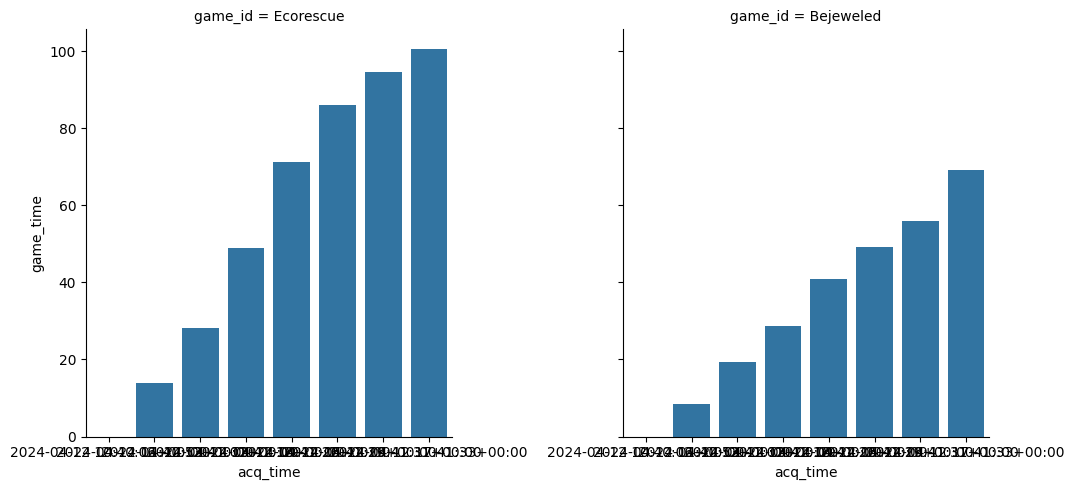

In [32]:
grid = sns.catplot(
    df, kind="bar", x="acq_time", y="game_time", col="game_id", errorbar=None
)
make_plot_prettier(grid)

Or maybe line plots of the total gametime per game in function of datetimes.

<Axes: xlabel='acq_time', ylabel='game_time'>

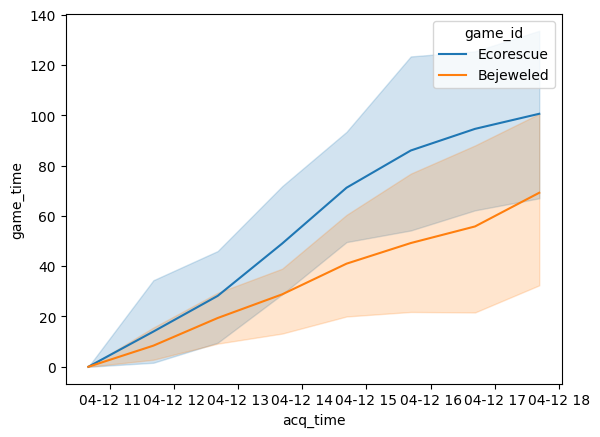

In [33]:
ax = sns.lineplot(df, x="acq_time", y="game_time", hue="game_id")
make_plot_prettier(ax)